### PyTorch Dataloaders
Look here https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel.

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

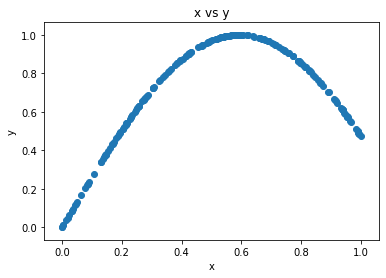

In [2]:
n = 300

df = pd.DataFrame()
df['time'] = np.random.randint(0,800,n)
df['value'] = 3 * np.sin(df.time/300) #+ np.random.normal(0,1,n)
df['split'] = np.random.randint(0,n,n)

time_split = n * 0.7

train_df = df[df.split < time_split]
val_df = df[df.split >= time_split]

#val_df.time = (val_df.time - np.min(train_df.time))/(np.max(train_df.time) - np.min(train_df.time))
train_df.time = (train_df.time - np.min(train_df.time))/(np.max(train_df.time) - np.min(train_df.time))

val_df.value = (val_df.value - np.min(train_df.value))/(np.max(train_df.value) - np.min(train_df.value))
train_df.value = (train_df.value - np.min(train_df.value))/(np.max(train_df.value) - np.min(train_df.value))

x_train = train_df.time.values.astype(np.float32).reshape((-1,1))
y_train = train_df.value.values.astype(np.float32).reshape((-1,1))

plt.scatter(x_train, y_train)
plt.title("x vs y")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [3]:
class GenericDataset(Dataset):

    def __init__(self, df):
        self.df = df.copy()

    def __len__(self):
        
        length = len(self.df)
        return length

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = np.array(self.df.iloc[idx].time).reshape(-1,1)
        y = np.array(self.df.iloc[idx].value).reshape(-1,1)

        return x, y

In [9]:
# Hyper-parameters
INPUT_SIZE = 1
OUTPUT_SIZE = 1
NUM_EPOCHS = 300
LEARNING_RATE = 0.01
BATCH_SIZE = 64

In [10]:
class MLPModel(nn.Module):
    def __init__(self, input_size, output_size, dropout=0.0, n_hid=1128):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, n_hid),
            nn.ReLU(),  
            #nn.Tanh(),
            nn.Linear(n_hid, n_hid),
            nn.ReLU(),  
            nn.Linear(n_hid, n_hid),
            nn.ReLU(), 
            #nn.Tanh(),
            nn.Linear(n_hid, output_size),
        )
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, input_tensor):
        return self.model(input_tensor)

In [23]:
# Linear regression model
model =  MLPModel(INPUT_SIZE, OUTPUT_SIZE)
model = model.double()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)  

### Training Without Batch Generator

In [12]:
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
for epoch in range(NUM_EPOCHS):

    permutation = torch.randperm(torch.from_numpy(x_train).size()[0])
    
    for i in range(0,torch.from_numpy(x_train).size()[0], BATCH_SIZE):
    
        indices = permutation[i:i+BATCH_SIZE]
        inputs, targets = x_train[indices], y_train[indices]
    
        # Convert numpy arrays to torch tensors
        inputs = torch.from_numpy(inputs)
        targets = torch.from_numpy(targets)

        # Forward pass
        outputs = model.forward(inputs)
        loss = criterion(outputs, targets)
    
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss.item()))

Epoch [1/300], Loss: 0.1342
Epoch [2/300], Loss: 2.1229
Epoch [3/300], Loss: 0.1976
Epoch [4/300], Loss: 1.6398
Epoch [5/300], Loss: 0.3577
Epoch [6/300], Loss: 0.2581
Epoch [7/300], Loss: 0.1464
Epoch [8/300], Loss: 0.1240
Epoch [9/300], Loss: 0.1156
Epoch [10/300], Loss: 0.0856
Epoch [11/300], Loss: 0.0690
Epoch [12/300], Loss: 0.0950
Epoch [13/300], Loss: 0.0867
Epoch [14/300], Loss: 0.0922
Epoch [15/300], Loss: 0.0811
Epoch [16/300], Loss: 0.0369
Epoch [17/300], Loss: 0.0930
Epoch [18/300], Loss: 0.0548
Epoch [19/300], Loss: 0.0866
Epoch [20/300], Loss: 0.0540
Epoch [21/300], Loss: 0.0848
Epoch [22/300], Loss: 0.0552
Epoch [23/300], Loss: 0.0451
Epoch [24/300], Loss: 0.0552
Epoch [25/300], Loss: 0.0448
Epoch [26/300], Loss: 0.0525
Epoch [27/300], Loss: 0.0519
Epoch [28/300], Loss: 0.0296
Epoch [29/300], Loss: 0.0577
Epoch [30/300], Loss: 0.0255
Epoch [31/300], Loss: 0.0461
Epoch [32/300], Loss: 0.0319
Epoch [33/300], Loss: 0.0313
Epoch [34/300], Loss: 0.0437
Epoch [35/300], Loss: 0

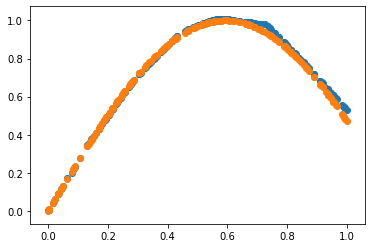

In [19]:
outputs = model.forward(torch.from_numpy(x_train))

plt.scatter(x_train, outputs.detach().numpy())
plt.scatter(x_train, y_train)

### Training with Batch Generator

In [24]:
x_train_tensor = torch.from_numpy(x_train)
y_train_tensor = torch.from_numpy(y_train)

x_train_tensor, y_train_tensor = Variable(x_train_tensor), Variable(y_train_tensor)

torch_dataset = Data.TensorDataset(x_train_tensor, y_train_tensor)

train_loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=1,)

val_loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=1,)

In [25]:
# Train the model
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    train_loss_epoch = []
    val_loss_epoch = []
    
    for step, (batch_x, batch_y) in enumerate(train_loader): # for each training step
        
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)
    
        # Clear old gradients.
        optimizer.zero_grad()
        
        # Make sure inputs/outputs are correct data type.
        b_x = b_x.double()
        b_y = b_y.double()

        # Forward pass
        outputs = model.forward(b_x)
        train_loss = criterion(outputs, b_y)
    
        # Backward and optimize
        train_loss.backward()
        optimizer.step()
        train_loss_epoch.append(train_loss.item())
        
    model.eval()
        
    for step, (batch_x, batch_y) in enumerate(val_loader):
            
        batch_x = batch_x.double()
        batch_y = batch_y.double()

        # Forward pass
        outputs = model.forward(batch_x)
        val_loss = criterion(outputs, batch_y)
        val_loss_epoch.append(val_loss.item())
    
    if (epoch+1) % 1 == 0:
        print('Epoch [{}/{}], Train loss: {:.4f}, Val loss: {:.4f}'.format(epoch+1, 
                                                                           NUM_EPOCHS, 
                                                                           np.mean(train_loss_epoch), 
                                                                           np.mean(val_loss_epoch)))

Epoch [1/300], Train loss: 9308.3799, Val loss: 0.1180
Epoch [2/300], Train loss: 5.7995, Val loss: 0.2601
Epoch [3/300], Train loss: 2.8398, Val loss: 7.5165
Epoch [4/300], Train loss: 3.5618, Val loss: 0.2404
Epoch [5/300], Train loss: 0.2320, Val loss: 0.2698
Epoch [6/300], Train loss: 0.1755, Val loss: 0.4851
Epoch [7/300], Train loss: 0.5468, Val loss: 0.1540
Epoch [8/300], Train loss: 0.2107, Val loss: 0.2423
Epoch [9/300], Train loss: 0.1722, Val loss: 0.1982
Epoch [10/300], Train loss: 0.1582, Val loss: 0.0932
Epoch [11/300], Train loss: 0.0852, Val loss: 0.0921
Epoch [12/300], Train loss: 0.0975, Val loss: 0.0991
Epoch [13/300], Train loss: 0.0897, Val loss: 0.0590
Epoch [14/300], Train loss: 0.1428, Val loss: 0.0840
Epoch [15/300], Train loss: 0.0824, Val loss: 0.0811
Epoch [16/300], Train loss: 0.0710, Val loss: 0.0485
Epoch [17/300], Train loss: 0.0580, Val loss: 0.0518
Epoch [18/300], Train loss: 0.0515, Val loss: 0.0393
Epoch [19/300], Train loss: 0.0383, Val loss: 0.0347

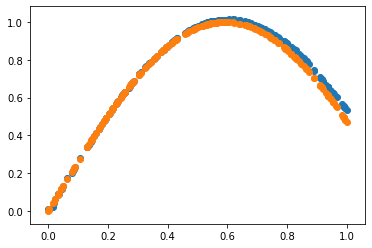

In [26]:
outputs = model.forward(torch.from_numpy(x_train).double())

plt.scatter(x_train, outputs.detach().numpy())
plt.scatter(x_train, y_train)

### Training With Custom Batch Generator

In [27]:
params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': 0}

training_set = GenericDataset(train_df)
training_generator = DataLoader(training_set, **params)

val_set = GenericDataset(val_df)
val_generator = DataLoader(val_set, **params)

In [28]:
# Train the model
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    train_loss_epoch = []
    val_loss_epoch = []
    
    for inputs, targets in training_generator:
    
        # Clear old gradients.
        optimizer.zero_grad()
        
        # Make sure inputs/outputs are correct data type.
        inputs = inputs.double()
        targets = targets.double()

        # Forward pass
        outputs = model.forward(inputs)
        train_loss = criterion(outputs, targets)
    
        # Backward and optimize
        train_loss.backward()
        optimizer.step()
        train_loss_epoch.append(train_loss.item())
        
    model.eval()
        
    for inputs, targets in val_generator:
            
        inputs = inputs.double()
        targets = targets.double()

        # Forward pass
        outputs = model.forward(inputs)
        val_loss = criterion(outputs, targets)
        val_loss_epoch.append(val_loss.item())
    
    if (epoch+1) % 1 == 0:
        print('Epoch [{}/{}], Train loss: {:.4f}, Val loss: {:.4f}'.format(epoch+1, 
                                                                           NUM_EPOCHS, 
                                                                           np.mean(train_loss_epoch), 
                                                                           np.mean(val_loss_epoch)))

Epoch [1/300], Train loss: 4.8098, Val loss: 604803.6626
Epoch [2/300], Train loss: 0.8649, Val loss: 120376.5016
Epoch [3/300], Train loss: 0.7942, Val loss: 309138.2371
Epoch [4/300], Train loss: 1.5331, Val loss: 1229487.4653
Epoch [5/300], Train loss: 1.6290, Val loss: 346408.7505
Epoch [6/300], Train loss: 1.0295, Val loss: 299086.9613
Epoch [7/300], Train loss: 0.3221, Val loss: 190893.3906
Epoch [8/300], Train loss: 0.1317, Val loss: 346744.0588
Epoch [9/300], Train loss: 0.0784, Val loss: 162474.8258
Epoch [10/300], Train loss: 0.0610, Val loss: 233135.3696
Epoch [11/300], Train loss: 0.0529, Val loss: 109867.6365
Epoch [12/300], Train loss: 0.0323, Val loss: 66875.3905
Epoch [13/300], Train loss: 0.0246, Val loss: 16470.5853
Epoch [14/300], Train loss: 0.0177, Val loss: 838.3561
Epoch [15/300], Train loss: 0.0159, Val loss: 780.8121
Epoch [16/300], Train loss: 0.0211, Val loss: 6329.8690
Epoch [17/300], Train loss: 0.0204, Val loss: 2392.6043
Epoch [18/300], Train loss: 0.0155

Epoch [280/300], Train loss: 0.0000, Val loss: 333335.1787
Epoch [281/300], Train loss: 0.0000, Val loss: 343779.9060
Epoch [282/300], Train loss: 0.0000, Val loss: 341169.5221
Epoch [283/300], Train loss: 0.0000, Val loss: 376291.9523
Epoch [284/300], Train loss: 0.0000, Val loss: 347917.2057
Epoch [285/300], Train loss: 0.0000, Val loss: 339033.2046
Epoch [286/300], Train loss: 0.0000, Val loss: 315897.4047
Epoch [287/300], Train loss: 0.0000, Val loss: 355312.5106
Epoch [288/300], Train loss: 0.0000, Val loss: 380582.4847
Epoch [289/300], Train loss: 0.0000, Val loss: 323606.2854
Epoch [290/300], Train loss: 0.0000, Val loss: 333621.8634
Epoch [291/300], Train loss: 0.0000, Val loss: 314125.5498
Epoch [292/300], Train loss: 0.0000, Val loss: 354892.7106
Epoch [293/300], Train loss: 0.0000, Val loss: 351943.1610
Epoch [294/300], Train loss: 0.0000, Val loss: 360032.7665
Epoch [295/300], Train loss: 0.0000, Val loss: 351996.6442
Epoch [296/300], Train loss: 0.0000, Val loss: 329020.42

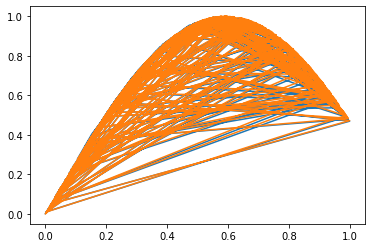

In [29]:
outputs = model.forward(torch.from_numpy(train_df['time'].values.reshape(-1,1)))

plt.plot(train_df.time, outputs.detach().numpy())
plt.plot(train_df.time, train_df.value)

In [48]:
import numpy as np
import matplotlib.pyplot as plt

In [63]:
def kullback_leibler(p, q):
    
    return np.sum(p * np.log(p/q))

N_OUTCOMES = 10

p = np.ones(N_OUTCOMES)/N_OUTCOMES
p = p / np.sum(p)

q = np.random.normal(0,1,N_OUTCOMES)
q = np.abs(q)
q = q / np.sum(q)

print("D_kl(p|q): {}".format(kullback_leibler(p, q)))
print("D_kl(q|p): {}".format(kullback_leibler(q, p)))

D_kl(p|q): 0.21038086747693785
D_kl(q|p): 0.18449058948939873


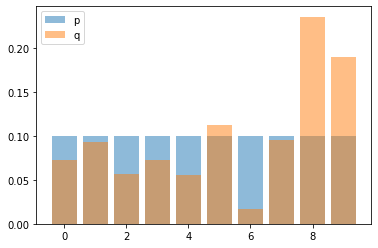

In [64]:
plt.bar(list(range(len(p))), p, label="p", alpha=0.5)

plt.bar(list(range(len(q))), q, label="q", alpha=0.5)
plt.legend()
plt.show()